# Yelp API Integration and Decision Tree Classifier

This project encompasses a comprehensive approach to sentiment analysis by leveraging the Yelp API, web scraping techniques, data preprocessing, and machine learning modeling. Here's a detailed breakdown of each step:

1. Connecting to the Yelp API: The initial stage involves connecting to the Yelp API to retrieve business information. This connection is crucial for accessing structured data about various businesses, such as their names, locations, and URLs to their Yelp review pages.

2. Web Scraping Reviews: Once we have the URLs from the Yelp API, the next step is to perform web scraping. This process involves making HTTP requests to each URL and parsing the HTML content to extract review text and ratings. We use BeautifulSoup, a Python library, to navigate through the HTML structure of the Yelp review pages and systematically extract the relevant data, typically limiting ourselves to a certain number of reviews per business due to display constraints on the web pages.

3. Balancing the Rating Data: An inherent challenge in sentiment analysis is dealing with imbalanced datasets, where one sentiment class (e.g., positive) might be overrepresented compared to another (e.g., negative). To address this, we use the "imblearn" library to either oversample the minority class or undersample the majority class. For this project, we chose oversampling, which enhances the dataset by replicating instances of the underrepresented class, thus providing a more balanced and richer dataset for training our model.

4. Sentiment Assignment: We then assign a sentiment label to each review. This is done by converting the numerical ratings into categorical sentiment labels—reviews with ratings of 4 or higher are labeled as 'positive', while those with ratings of 3 or lower are labeled as 'negative'. This binary classification aligns with typical sentiment analysis objectives, simplifying the model's task.

5. Building a Classification Model: The core of this project is the development of a machine learning model for sentiment classification. We employ a decision tree classifier, a fundamental yet powerful algorithm in machine learning. Decision trees are particularly suited for this task due to their ability to handle varied feature types and their interpretability. They work by learning decision rules inferred from the data features.

6. Text Analysis Processes: Alongside the numerical analysis of ratings, we also perform text analysis on the review content. This involves extracting features from the text data, such as word frequencies or presence of specific keywords or phrases, which are then fed into the decision tree classifier. The combination of text analysis with the sentiment labels allows the model to learn how different textual patterns correlate with positive or negative sentiments.

7. Model Evaluation and Refinement: Once the model is built, we evaluate its performance using standard metrics like accuracy, precision, recall, and the confusion matrix. Based on these evaluations, we refine the model through techniques like hyperparameter tuning or feature selection to enhance its predictive accuracy.

8. Final Output: The end goal of this project is to create a robust model capable of accurately classifying Yelp reviews into positive or negative sentiments. This model can be utilized for various purposes, such as understanding customer satisfaction, gauging public opinion on certain services or establishments, or even guiding business strategy.

Each step in this project contributes to the overarching goal of developing a reliable sentiment analysis tool using data from Yelp, showcasing the interplay between API data retrieval, web scraping, data preprocessing, and machine learning.

pip install requests

pip install imbalanced-learn

pip install beautifulsoup4

In [98]:
import requests
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import time
import urllib.parse as urlparse
import random
import re
import pandas as pd
import requests
from bs4 import BeautifulSoup
import json
import seaborn as sns

In [3]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

In [153]:
YELP_TOKEN = "Generate_Yelp_API_and_insert_here"

In [11]:
r = requests.get("https://api.yelp.com/v3/businesses/search?location=Toronto&limit=50", headers={"Authorization": "Bearer %s" % YELP_TOKEN})

In [12]:
print(r.status_code, r.reason, r.content)

200 OK b'{"businesses": [{"id": "r_BrIgzYcwo1NAuG9dLbpg", "alias": "pai-northern-thai-kitchen-toronto-5", "name": "Pai Northern Thai Kitchen", "image_url": "https://s3-media4.fl.yelpcdn.com/bphoto/uAnTcmLEQJWkCUOtvZMALA/o.jpg", "is_closed": false, "url": "https://www.yelp.com/biz/pai-northern-thai-kitchen-toronto-5?adjust_creative=bSrEjknh1dh3fwOy0ec42g&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=bSrEjknh1dh3fwOy0ec42g", "review_count": 3559, "categories": [{"alias": "thai", "title": "Thai"}], "rating": 4.5, "coordinates": {"latitude": 43.64784, "longitude": -79.38872}, "transactions": [], "price": "$$", "location": {"address1": "18 Duncan Street", "address2": "", "address3": "", "city": "Toronto", "zip_code": "M5H 3G8", "country": "CA", "state": "ON", "display_address": ["18 Duncan Street", "Toronto, ON M5H 3G8", "Canada"]}, "phone": "+14169014724", "display_phone": "+1 416-901-4724", "distance": 3009.3347434869856}, {"id": "mZRKH9ngRY92bI_irrHq6w", "alias": 

In [13]:
r.json()

{'businesses': [{'id': 'r_BrIgzYcwo1NAuG9dLbpg',
   'alias': 'pai-northern-thai-kitchen-toronto-5',
   'name': 'Pai Northern Thai Kitchen',
   'image_url': 'https://s3-media4.fl.yelpcdn.com/bphoto/uAnTcmLEQJWkCUOtvZMALA/o.jpg',
   'is_closed': False,
   'url': 'https://www.yelp.com/biz/pai-northern-thai-kitchen-toronto-5?adjust_creative=bSrEjknh1dh3fwOy0ec42g&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=bSrEjknh1dh3fwOy0ec42g',
   'review_count': 3559,
   'categories': [{'alias': 'thai', 'title': 'Thai'}],
   'rating': 4.5,
   'coordinates': {'latitude': 43.64784, 'longitude': -79.38872},
   'transactions': [],
   'price': '$$',
   'location': {'address1': '18 Duncan Street',
    'address2': '',
    'address3': '',
    'city': 'Toronto',
    'zip_code': 'M5H 3G8',
    'country': 'CA',
    'state': 'ON',
    'display_address': ['18 Duncan Street', 'Toronto, ON M5H 3G8', 'Canada']},
   'phone': '+14169014724',
   'display_phone': '+1 416-901-4724',
   'distance':

In [14]:
review_labels = []
for business in r.json()['businesses']:
    reviews = requests.get("https://api.yelp.com/v3/businesses/%s/reviews" % business['id'], headers={"Authorization": "Bearer %s" % YELP_TOKEN}).json()
    for review in reviews['reviews']:
        review_labels.append((review['text'].rstrip('.'), review['rating']))
review_labels

[('Superb. Great food and great service. Be advised debit/credit only no cash. Always a great choice',
  5),
 ('Food is always amazing,I recommend the pad see ew. People from other cities who come here love it',
  5),
 ("Great restaurant! Worth a bit of a wait in the line, which you can't really avoid. Tried a few different curries and loved them all, both the taste and the",
  5),
 ("We've been twice now to have the Chef's Tasting menu and both times the service, the food and the ambiance have been unbelievable. All the staff is so sweet",
  5),
 ('Visited Richmond Station while on a business trip to Toronto, and it was a great experience. I appreciated the friendly staff and the cozy vibe. The locally',
  5),
 ("Service was excellent, wasn't too loud in the restaurant, I found this to be an enjoyable experience! \n\nPersonally felt like the food was average, I'm",
  3),
 ('Osteria Giulia is a great place to enjoy a romantic dinner with your loved one. A cozy Italian restaurant locate

In [15]:
review_features = [(x.split(' '), 'positive' if y > 3 else 'negative') for (x, y) in review_labels]
review_features

[(['Superb.',
   'Great',
   'food',
   'and',
   'great',
   'service.',
   'Be',
   'advised',
   'debit/credit',
   'only',
   'no',
   'cash.',
   'Always',
   'a',
   'great',
   'choice'],
  'positive'),
 (['Food',
   'is',
   'always',
   'amazing,I',
   'recommend',
   'the',
   'pad',
   'see',
   'ew.',
   'People',
   'from',
   'other',
   'cities',
   'who',
   'come',
   'here',
   'love',
   'it'],
  'positive'),
 (['Great',
   'restaurant!',
   'Worth',
   'a',
   'bit',
   'of',
   'a',
   'wait',
   'in',
   'the',
   'line,',
   'which',
   'you',
   "can't",
   'really',
   'avoid.',
   'Tried',
   'a',
   'few',
   'different',
   'curries',
   'and',
   'loved',
   'them',
   'all,',
   'both',
   'the',
   'taste',
   'and',
   'the'],
  'positive'),
 (["We've",
   'been',
   'twice',
   'now',
   'to',
   'have',
   'the',
   "Chef's",
   'Tasting',
   'menu',
   'and',
   'both',
   'times',
   'the',
   'service,',
   'the',
   'food',
   'and',
   'the',
   '

In [16]:
from nltk.sentiment import SentimentAnalyzer
import nltk.sentiment.util
from nltk.classify import NaiveBayesClassifier

random.shuffle(review_features)
training_docs = review_features[:120]
test_docs = review_features[120:]

print("Training: %d, Testing: %d" % (len(training_docs), len(test_docs)))

sentim_analyzer = SentimentAnalyzer()

Training: 120, Testing: 30


In [17]:
all_words_neg = sentim_analyzer.all_words([nltk.sentiment.util.mark_negation(doc) for doc in training_docs])
all_words_neg

['Service',
 'Complaint',
 '-',
 'Intimidation/Harassment/Abuse\n\nI',
 'have',
 'never',
 'posted_NEG',
 'a_NEG',
 'negative_NEG',
 'review,_NEG',
 'but_NEG',
 'my_NEG',
 'experience_NEG',
 'with_NEG',
 'Cactus_NEG',
 'Club_NEG',
 'Cafe_NEG',
 'was_NEG',
 'horrific,_NEG',
 'Tried',
 'the',
 'Canoe',
 'tasting',
 'menu',
 'and',
 'I',
 'must',
 'say,',
 'they',
 'do',
 'not',
 'disappoint._NEG',
 '\n\nThe_NEG',
 'tasting_NEG',
 'menu_NEG',
 'consist_NEG',
 'of:\nsmoked_NEG',
 'oyster_NEG',
 '(charred_NEG',
 'game,_NEG',
 'puffed_NEG',
 'rice)_NEG',
 '+_NEG',
 'nori_NEG',
 'In',
 'classic',
 'fashion,',
 'the',
 'space',
 'is',
 'pretty',
 'tight',
 'and',
 'generally',
 'a',
 'little',
 'difficult',
 'to',
 'navigate.',
 'Still,',
 'we',
 'were',
 'lucky',
 'to',
 'pop',
 'in',
 'and',
 'grab',
 'the',
 'last',
 'two',
 'counter',
 'We',
 'had',
 'the',
 'boar',
 'chop',
 'which',
 'was',
 'excellent',
 'as',
 'well',
 'as',
 'the',
 'rib',
 'eye.',
 '',
 'The',
 'smoked',
 'wedge',
 '

In [18]:
training_set = sentim_analyzer.apply_features(training_docs)
test_set = sentim_analyzer.apply_features(test_docs)

In [19]:
trainer = NaiveBayesClassifier.train
classifier = sentim_analyzer.train(trainer, training_set)
for key,value in sorted(sentim_analyzer.evaluate(test_set).items()):
     print('{0}: {1}'.format(key, value))

Training classifier
Evaluating NaiveBayesClassifier results...
Accuracy: 0.8333333333333334
F-measure [negative]: None
F-measure [positive]: 0.9090909090909091
Precision [negative]: None
Precision [positive]: 0.8333333333333334
Recall [negative]: 0.0
Recall [positive]: 1.0


# Lets Begin

The function "get_reviews" takes an HTML document as input and parses it to extract information about restaurant reviews from the yelp page of individual restuarants. The function performs the following actions:

- It initializes a BeautifulSoup object with the provided HTML content to parse and navigate the HTML structure.

- It initializes an empty list reviews to store the data extracted from each review block.

- It attempts to find the restaurant name by searching for an h1 tag with a specific class. If the tag is found, it extracts the text content; otherwise, it defaults to 'No restaurant name found'.

- It then finds all the list item (li) elements with a specified class that are assumed to be the containers for individual reviews.

- For each of these li elements (review blocks):

    -It finds and extracts the review text, which is contained in a paragraph (p) tag with a specific class.

    -It finds a div element with a class and an aria-label attribute that contains the rating information. It extracts the rating text using the aria-label attribute.

    -It uses a regular expression to extract only the numeric part of the rating text (e.g., extracting "4" from "4 star rating").

    -It appends a dictionary with the restaurant name, review text, and numeric rating to the reviews list.

Once all review blocks have been processed, the function returns the reviews list, which contains dictionaries with data for each review.

This function is designed to scrape review data from a webpage for a given restaurant. Each dictionary in the returned list represents a single review with the name of the restaurant, the text of the review, and the numeric rating.

In [152]:
def get_reviews(html):
    soup = BeautifulSoup(html, 'html.parser')
    reviews = []
    
    # Find the restaurant name by locating the h1 tag with the appropriate class
    restaurant_name = soup.find('h1', class_="css-1se8maq").get_text(strip=True) if soup.find('h1', class_="css-1se8maq") else 'No restaurant name found'

    review_blocks = soup.find_all('li', class_="css-1q2nwpv")  # Parent class for each review block
    for block in review_blocks:
        review_text = block.find('p', class_="comment__09f24__D0cxf css-qgunke").get_text(strip=True)
        
        # Correctly find the div with the class and aria-label attribute
        rating_div = block.find('div', {'class': "css-14g69b3", 'aria-label': True})
        rating_text = rating_div.get('aria-label') if rating_div else 'No rating found'
        
        match = re.search(r'(\d+)', rating_text)
        rating = match.group(0) if match else 'No rating'
        
        reviews.append({
            'restaurant': restaurant_name,
            'text': review_text,
            'rating': rating
        })
    return reviews


Here is a test-run of the function "get_reviews"

In [21]:
# Use requests to fetch the HTML content from the URL
url = 'https://www.yelp.com/biz/koh-lipe-toronto-2?adjust_creative=bSrEjknh1dh3fwOy0ec42g&hrid=2H0hWTqV26p7KhgIDVMqfQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=bSrEjknh1dh3fwOy0ec42g'
response = requests.get(url)

if response.ok:
    reviews = get_reviews(response.text)
    for review in reviews:
        print("Restaurant Name:", review['restaurant'])
        print("Review Text:", review['text'])
        print("Rating:", review['rating'])
        print("------------ End of Review ------------\n")
else:
    print("Failed to retrieve the page")

Restaurant Name: Koh Lipe
Review Text: We felt like Thai for dinner and decided to visit this neighborhood joint, and we're far from disappointed! The place had an amazing Thai vibe, two floors and a patio that was jam packed with patrons. We had to wait about 30 minutes for a table, but there were so many places just outside to look at.We started with the coconut soup, with chicken. The aroma with such a milk infusion of lemon grass, citrus and coconut hits your face as the waiter places in front of you, and I have to admit that's when I started heavily salivating. The soup was loaded with fresh chicken slices, and topped with coriander, great combination, and a little on the spicy side, just how we like it.I had the Thai ice tea, and it really does taste like what they make in Thailand, there was a delicate balance of herbs, a robust tea taste, and the sweet creaminess of the condensed milk, wow, perfection! I would highly recommend this if your into Thai ice tea. In fact I would pro

I am initializing and storing the information in a DataFrame to facilitate its use in the subsequent classification model.

In [23]:
reviews_data = get_reviews(response.text)
reviews_df = pd.DataFrame(reviews_data)

reviews_df

,restaurant,text,rating
0,Koh Lipe,We felt like Thai for dinner and decided to vi...,4
1,Koh Lipe,"Koh Lipe is on the Michelin Guide, which peake...",5
2,Koh Lipe,What is the big deal?I have had better. The se...,2
3,Koh Lipe,There is street parking. They have an area lik...,4
4,Koh Lipe,Delicious! Really yummy Thai food and I love t...,5
5,Koh Lipe,This place absolutely deserves its Michelin bi...,5
6,Koh Lipe,"It's my third time back here, and I was not di...",4
7,Koh Lipe,I read an article about how great this restaur...,4
8,Koh Lipe,I came to dinner at Koh Lipe with a friend on ...,3
9,Koh Lipe,From savory appetizers to mouthwatering main c...,5


This code below does the following:
    
- It extracts URLs from a JSON response that contains business information, specifically focusing on the 'url' key within each 'business' object.

- Using a loop, it iterates through each URL to make an HTTP GET request for the corresponding webpage.

- If the HTTP request is successful (the response is OK), it calls the get_reviews function with the HTML content of the page. This function is expected to parse the HTML and extract review information, returning it as a list of dictionaries where each dictionary contains data from an individual review.

- It adds the extracted reviews from each webpage to a master list all_reviews using the extend method. This method is chosen over append to ensure that each review is added as an individual element to the list rather than as a nested list.

- After collecting reviews from all provided URLs, it converts the all_reviews list into a pandas DataFrame, which provides a structured format suitable for data analysis or feeding into a machine learning model.

- Finally, it displays the DataFrame, which now contains all the review data extracted from the webpages.

I have successfully extracted complete reviews for each restaurant. Due to a limitation of 50 businesses, I have retrieved approximately 10 reviews per business, which corresponds to the number of reviews typically displayed on a single page of each restaurant's review section on Yelp.

In [24]:
# Extract the URLs from the JSON data
urls = [business['url'] for business in r.json()['businesses']]

# Use the URLs to get reviews for each business
all_reviews = []
for url in urls:
    response = requests.get(url)  # Make an HTTP request to get the HTML content
    if response.ok:
        reviews = get_reviews(response.text)  # Pass the HTML content to your function
        all_reviews.extend(reviews)  # Use extend instead of append to flatten the list of reviews
    else:
        print(f"Failed to retrieve the page at {url}")

# Convert all reviews to a pandas DataFrame
reviews_df = pd.DataFrame(all_reviews)
reviews_df




,restaurant,text,rating
0,Pai Northern Thai Kitchen,Superb. Great food and great service. Be advis...,5
1,Pai Northern Thai Kitchen,"Food is always amazing,I recommend the pad see...",5
2,Pai Northern Thai Kitchen,Great restaurant! Worth a bit of a wait in the...,5
3,Pai Northern Thai Kitchen,- excellent chips!- pad thai was spicy (level:...,5
4,Pai Northern Thai Kitchen,"My friend loves this restaurant. Me, well, it'...",3
...,...,...,...
455,Bar Isabel,Excited for this place since I always see it o...,4
456,Bar Isabel,A cozy place on the western part of College St...,4
457,Bar Isabel,Best restaurant in Toronto that we had.The vib...,5
458,Bar Isabel,When I can't go to Spain I come to this OG Spa...,5


This saves the reviews as csv for my machine learning classification model.

In [25]:
# Optionally, save the DataFrame to a CSV file
reviews_df.to_csv('yelp_reviews.csv', index=False)

In [26]:
reviews_df['restaurant'].nunique()

46

In [27]:
reviews_df['rating'].value_counts()

rating
5    226
4    153
3     60
2     12
1      9
Name: count, dtype: int64

This code below defines a function to assign sentiment labels to restaurant reviews based on their ratings, filters reviews for sentiment, and saves the data in a specific format:

- The assign_sentiment function classifies ratings as 'negative' if 3 or below and 'positive' if 4 or above.

- It iterates over all the reviews in all_reviews, which is a list of dictionaries where each dictionary represents a review. It assigns a sentiment label to each review by calling the assign_sentiment function with the first character of the 'rating' string converted to an integer.

- Reviews with a 'neutral' sentiment (which would be those with a rating of exactly 3, but this condition is not explicitly handled in the given code) are filtered out. The remaining reviews are considered to have a 'positive' or 'negative' sentiment.

Note: The decision to omit a specific label for neutral sentiment is deliberate, accommodating the possibility that a rating of 3 may not necessarily equate to either positive or negative sentiment. For the purpose of creating a more nuanced dataset, I am operating under the assumption that a rating of 3 reflects an ambivalence in customer sentiment, which does not contribute to a clear positive sentiment category.

- It transforms the sentiment-labeled reviews into a list of lists, where each inner list contains the review text and its assigned sentiment label.

- Finally, the list of sentiment-labeled reviews is saved to a file named 'data.json', using UTF-8 encoding to support non-ASCII characters. The JSON is formatted with an indent level of 2 for readability.







In [28]:
def assign_sentiment(rating):
    if rating <= 3:
        return "negative"
    elif rating >= 4:
        return "positive"


# Assign sentiment to each review
for review in all_reviews:
    review['sentiment'] = assign_sentiment(int(review['rating'][0]))  # Assuming rating is like "4 star rating"

# Filter out neutral reviews if desired
sentiment_reviews = [review for review in all_reviews if review['sentiment'] != "neutral"]

# Convert to the required format for data.json
data_to_save = [[review['text'], review['sentiment']] for review in sentiment_reviews]
    
with open('data.json', 'w', encoding='utf-8') as f:
    json.dump(data_to_save, f, ensure_ascii=False, indent=2)


In [29]:
from nltk.sentiment import SentimentAnalyzer
import nltk.sentiment.util
from nltk.classify import NaiveBayesClassifier

random.shuffle(data_to_save)
training_docs = data_to_save[:380]
test_docs = data_to_save[380:]

print("Training: %d, Testing: %d" % (len(training_docs), len(test_docs)))

sentim_analyzer = SentimentAnalyzer()

Training: 380, Testing: 80


In [30]:
all_words_neg = sentim_analyzer.all_words([nltk.sentiment.util.mark_negation(doc) for doc in training_docs])
all_words_neg

['Sat outside and it was pretty lovely. Overall was alright. Everything was pretty overpriced, took a while to come out, and tasted okay.One stand out though that knocks it up to a 4 star was their grilled mushrooms with shaved egg yolk - definitely recommend getting that if you go.',
 'positive',
 "I recently dined at this wonderful restaurant, and it was an exceptional experience in every way. First and foremost, the people here are truly remarkable. The staff was not only professional but also incredibly warm and welcoming, making us feel like cherished guests from the moment we walked in.Now, let's talk about the food - it was simply outstanding. Each dish we ordered was a masterpiece of flavor and presentation. From the appetizers to the dessert, every bite was a culinary delight. The chef's attention to detail and commitment to quality ingredients were evident in every dish.And the location! It's a charming spot that adds to the overall ambiance. We were lucky enough to dine on t

In [31]:
training_set = sentim_analyzer.apply_features(training_docs)
test_set = sentim_analyzer.apply_features(test_docs)

In [32]:
trainer = NaiveBayesClassifier.train
classifier = sentim_analyzer.train(trainer, training_set)
for key,value in sorted(sentim_analyzer.evaluate(test_set).items()):
     print('{0}: {1}'.format(key, value))

Training classifier
Evaluating NaiveBayesClassifier results...
Accuracy: 0.8375
F-measure [negative]: None
F-measure [positive]: 0.9115646258503401
Precision [negative]: None
Precision [positive]: 0.8375
Recall [negative]: 0.0
Recall [positive]: 1.0


<BarContainer object of 5 artists>

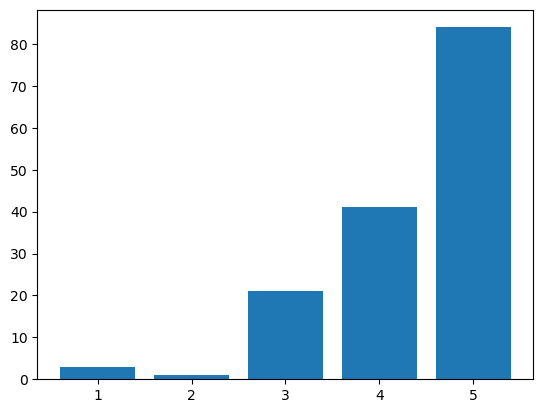

In [33]:
from collections import defaultdict

c = defaultdict(int)
for x in review_labels:
    c[x[1]] += 1

plt.bar(c.keys(), c.values())

# Text Analysis and Decision Tree Classifier

## In this section, I have choosen to implement a tokenizer and test the classification accuracy of a model trained on this dataset using a decision tree model

After implementing and refining the model, I achieved an initial accuracy of 81%. This was enhanced to 85% following hyperparameter tuning. Notably, this represents a modest increase compared to the simple sentiment classifier, which consistently achieved an accuracy of 83% before and after the analysis of the full review text.

In this section, I also addressed the issue of dataset imbalance. Utilizing the "imblearn" Python library, I applied oversampling to the sparse class to achieve a better balance. I explored both oversampling and undersampling strategies and ultimately opted for oversampling, as it provided a more robust dataset for the model.

In [36]:
from string import punctuation
import nltk
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz
%matplotlib inline
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from string import punctuation
from dmba import classificationSummary

In [37]:
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [38]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ehich\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

pip install dmba

pip install openpyxl

In [39]:
stop_words = set(stopwords.words('english'))
print(stop_words)

{'been', 'below', 'what', 'not', 'o', 'y', "weren't", 'll', "don't", 'do', 'but', 'there', 'me', 'themselves', 'whom', "wasn't", 'off', 'only', 'them', 'i', 'it', "you're", 'him', 'are', 'hadn', 'which', 'haven', 'from', "mustn't", 'while', 'has', 's', 'am', 'ourselves', 'or', 'here', 'each', 'herself', 'yourself', 'all', 'needn', 'once', 'until', 'they', "shan't", 'ma', 'a', 'weren', 'does', 'to', 'mustn', 'now', 've', 'then', 'shouldn', 'if', 'myself', 't', "doesn't", 'for', 'so', 'be', 'between', 'hers', 'yours', 'its', 'into', 'down', 'of', 'didn', "shouldn't", "couldn't", "won't", 'we', "you'll", 'that', 'further', 'itself', 'no', 'by', 'just', "she's", 'was', 'nor', 'above', "needn't", 'an', 'yourselves', 'very', 'isn', 'over', 'her', 'again', 'ain', 'have', 'about', 'other', 'through', 'why', "that'll", 'such', 'had', 'where', 'can', 'our', 'more', 'this', 'couldn', 'himself', 'after', 'aren', "you'd", 're', 'most', "didn't", "mightn't", 'who', 'in', 'under', 'these', 'hasn', 'h

## Data-Cleaning and Preparation 

In [40]:
reviews_df = pd.read_csv('yelp_reviews.csv')

In [41]:
reviews_df

,restaurant,text,rating
0,Pai Northern Thai Kitchen,Superb. Great food and great service. Be advis...,5
1,Pai Northern Thai Kitchen,"Food is always amazing,I recommend the pad see...",5
2,Pai Northern Thai Kitchen,Great restaurant! Worth a bit of a wait in the...,5
3,Pai Northern Thai Kitchen,- excellent chips!- pad thai was spicy (level:...,5
4,Pai Northern Thai Kitchen,"My friend loves this restaurant. Me, well, it'...",3
...,...,...,...
455,Bar Isabel,Excited for this place since I always see it o...,4
456,Bar Isabel,A cozy place on the western part of College St...,4
457,Bar Isabel,Best restaurant in Toronto that we had.The vib...,5
458,Bar Isabel,When I can't go to Spain I come to this OG Spa...,5


In [42]:
reviews_df.shape

(460, 3)

In [43]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   restaurant  460 non-null    object
 1   text        460 non-null    object
 2   rating      460 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 10.9+ KB


In [44]:
text_df = pd.DataFrame(reviews_df["text"])

In [45]:
text_df

,text
0,Superb. Great food and great service. Be advis...
1,"Food is always amazing,I recommend the pad see..."
2,Great restaurant! Worth a bit of a wait in the...
3,- excellent chips!- pad thai was spicy (level:...
4,"My friend loves this restaurant. Me, well, it'..."
...,...
455,Excited for this place since I always see it o...
456,A cozy place on the western part of College St...
457,Best restaurant in Toronto that we had.The vib...
458,When I can't go to Spain I come to this OG Spa...


In [46]:
def clean_text(text):
    tokens = text.split()
    table = str.maketrans('','',punctuation)
    tokens = [word.translate(table) for word in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word.lower() for word in tokens]
    tokens = [word for word in tokens if not word in stop_words]
    tokens = [word for word in tokens if len(word) > 1]
    return ' '.join(tokens)

In [47]:
text_df = text_df.text.apply(clean_text)

In [48]:
text_list = list(text_df)
text_list

['superb great food great service advised debitcredit cash always great choice',
 'food always amazingi recommend pad see ew people cities come love',
 'great restaurant worth bit wait line cant really avoid tried different curries loved taste presentation cosy atmosphere made quickly understand many famous people visited restaurant love story behind place cool basketball posters good service',
 'excellent chips pad thai spicy level spicy thai spicy pieces shrimp fried shrimp excellent really good pineapple juicethe venue huge fun good vibes food came fast portions large got upbeat partytype vibe lot bigger looksprices reasonable higher end thai general excellent food nonethelessshame thai iced coffee',
 'friend loves restaurant well ok way crowded inside people waiting tables seated makes uncomfortable dining experience got high table tall stools dining experience host said chance switch regular table uncomfortable put coats purses feet dangled ordered pork skewers app tasty curry dis

In [49]:
from keras.preprocessing.text import Tokenizer

In [50]:
tokenizer = Tokenizer()

In [51]:
tokenizer.fit_on_texts(text_list)

In [52]:
tokenizer.word_index

{'food': 1,
 'good': 2,
 'great': 3,
 'service': 4,
 'place': 5,
 'also': 6,
 'one': 7,
 'like': 8,
 'menu': 9,
 'would': 10,
 'really': 11,
 'us': 12,
 'time': 13,
 'restaurant': 14,
 'delicious': 15,
 'well': 16,
 'dish': 17,
 'nice': 18,
 'got': 19,
 'get': 20,
 'came': 21,
 'experience': 22,
 'ordered': 23,
 'definitely': 24,
 'table': 25,
 'best': 26,
 'bit': 27,
 'back': 28,
 'sauce': 29,
 'dishes': 30,
 'go': 31,
 'server': 32,
 'recommend': 33,
 'come': 34,
 'made': 35,
 'toronto': 36,
 'try': 37,
 'amazing': 38,
 'could': 39,
 'night': 40,
 'meal': 41,
 'chicken': 42,
 'ive': 43,
 'dinner': 44,
 'bar': 45,
 'staff': 46,
 'even': 47,
 'little': 48,
 'fresh': 49,
 'small': 50,
 'pretty': 51,
 'much': 52,
 'im': 53,
 'first': 54,
 'wasnt': 55,
 'ramen': 56,
 'didnt': 57,
 'drinks': 58,
 'taste': 59,
 'quite': 60,
 'dessert': 61,
 'dining': 62,
 'perfect': 63,
 'course': 64,
 'steak': 65,
 'love': 66,
 'order': 67,
 'special': 68,
 'friendly': 69,
 'pasta': 70,
 'super': 71,
 'exc

In [53]:
col_names = list(tokenizer.word_index)
col_names

['food',
 'good',
 'great',
 'service',
 'place',
 'also',
 'one',
 'like',
 'menu',
 'would',
 'really',
 'us',
 'time',
 'restaurant',
 'delicious',
 'well',
 'dish',
 'nice',
 'got',
 'get',
 'came',
 'experience',
 'ordered',
 'definitely',
 'table',
 'best',
 'bit',
 'back',
 'sauce',
 'dishes',
 'go',
 'server',
 'recommend',
 'come',
 'made',
 'toronto',
 'try',
 'amazing',
 'could',
 'night',
 'meal',
 'chicken',
 'ive',
 'dinner',
 'bar',
 'staff',
 'even',
 'little',
 'fresh',
 'small',
 'pretty',
 'much',
 'im',
 'first',
 'wasnt',
 'ramen',
 'didnt',
 'drinks',
 'taste',
 'quite',
 'dessert',
 'dining',
 'perfect',
 'course',
 'steak',
 'love',
 'order',
 'special',
 'friendly',
 'pasta',
 'super',
 'excellent',
 'went',
 'side',
 'everything',
 'spot',
 'beef',
 'sweet',
 'ambiance',
 'next',
 'enjoyed',
 'right',
 'every',
 'pork',
 'salad',
 'crispy',
 'dont',
 'bread',
 'youre',
 'cooked',
 'wait',
 'nothing',
 'loved',
 'perfectly',
 'tried',
 'fried',
 'two',
 'overal

In [54]:
word_bag = tokenizer.texts_to_matrix(text_list, mode='binary')
word_bag

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 1., 1.]])

In [55]:
word_bag_df = pd.DataFrame(word_bag)
word_bag_df.columns = ["dummy"] + col_names
word_bag_df

,dummy,food,good,great,service,place,also,one,like,menu,...,saucecured,chorizo,meatfoie,caramalized,butterythe,romanticthe,loversthe,manner,expectedfor,dotldr
0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
456,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
457,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
458,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [56]:
word_bag_df.shape

(460, 6575)

In [57]:
word_bag_df.sum()

dummy            0.0
food           235.0
good           188.0
great          174.0
service        188.0
               ...  
romanticthe      1.0
loversthe        1.0
manner           1.0
expectedfor      1.0
dotldr           1.0
Length: 6575, dtype: float64

In [58]:
keywords = pd.DataFrame(word_bag_df.sum().sort_values(ascending=False)).head(50)
keywords

,0
food,235.0
good,188.0
service,188.0
great,174.0
place,156.0
also,148.0
like,132.0
one,131.0
time,121.0
would,120.0


In [59]:
keywords.to_dict()

{0: {'food': 235.0,
  'good': 188.0,
  'service': 188.0,
  'great': 174.0,
  'place': 156.0,
  'also': 148.0,
  'like': 132.0,
  'one': 131.0,
  'time': 121.0,
  'would': 120.0,
  'delicious': 116.0,
  'menu': 115.0,
  'came': 111.0,
  'us': 108.0,
  'restaurant': 106.0,
  'well': 106.0,
  'get': 106.0,
  'really': 106.0,
  'nice': 104.0,
  'dish': 98.0,
  'experience': 97.0,
  'back': 97.0,
  'definitely': 97.0,
  'ordered': 96.0,
  'got': 91.0,
  'made': 85.0,
  'best': 85.0,
  'recommend': 83.0,
  'bit': 82.0,
  'dishes': 79.0,
  'go': 79.0,
  'try': 78.0,
  'toronto': 78.0,
  'come': 77.0,
  'amazing': 76.0,
  'server': 75.0,
  'sauce': 75.0,
  'could': 73.0,
  'night': 73.0,
  'table': 69.0,
  'meal': 69.0,
  'staff': 68.0,
  'even': 68.0,
  'ive': 66.0,
  'much': 66.0,
  'dinner': 65.0,
  'little': 65.0,
  'first': 63.0,
  'chicken': 63.0,
  'bar': 61.0}}

In [60]:
keywords_dict = keywords.to_dict()[0]
keywords_dict

{'food': 235.0,
 'good': 188.0,
 'service': 188.0,
 'great': 174.0,
 'place': 156.0,
 'also': 148.0,
 'like': 132.0,
 'one': 131.0,
 'time': 121.0,
 'would': 120.0,
 'delicious': 116.0,
 'menu': 115.0,
 'came': 111.0,
 'us': 108.0,
 'restaurant': 106.0,
 'well': 106.0,
 'get': 106.0,
 'really': 106.0,
 'nice': 104.0,
 'dish': 98.0,
 'experience': 97.0,
 'back': 97.0,
 'definitely': 97.0,
 'ordered': 96.0,
 'got': 91.0,
 'made': 85.0,
 'best': 85.0,
 'recommend': 83.0,
 'bit': 82.0,
 'dishes': 79.0,
 'go': 79.0,
 'try': 78.0,
 'toronto': 78.0,
 'come': 77.0,
 'amazing': 76.0,
 'server': 75.0,
 'sauce': 75.0,
 'could': 73.0,
 'night': 73.0,
 'table': 69.0,
 'meal': 69.0,
 'staff': 68.0,
 'even': 68.0,
 'ive': 66.0,
 'much': 66.0,
 'dinner': 65.0,
 'little': 65.0,
 'first': 63.0,
 'chicken': 63.0,
 'bar': 61.0}

pip install wordcloud

In [61]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [62]:
cloud_of_words = WordCloud(background_color="white").generate_from_frequencies(keywords_dict)

(-0.5, 399.5, 199.5, -0.5)

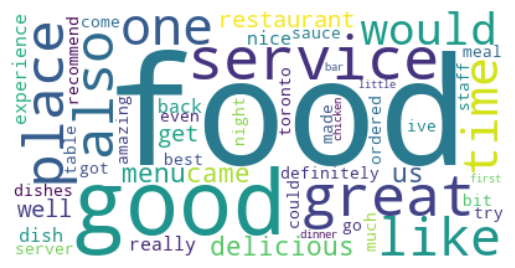

In [63]:
plt.imshow(cloud_of_words, interpolation='bilinear')
plt.axis('off')

In [64]:
keywords_sub = keywords[keywords.index.isin(['good', 'like', 'great', 'food', 'service'])]

In [65]:
keywords_sub

,0
food,235.0
good,188.0
service,188.0
great,174.0
like,132.0


In [66]:
keywords_dict = keywords_sub.to_dict()[0]
keywords_dict

{'food': 235.0, 'good': 188.0, 'service': 188.0, 'great': 174.0, 'like': 132.0}

In [67]:
cloud_of_words = WordCloud(background_color="white").generate_from_frequencies(keywords_dict)

(-0.5, 399.5, 199.5, -0.5)

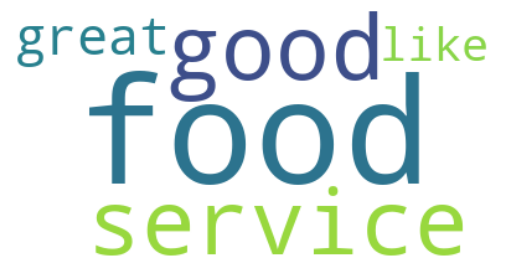

In [68]:
plt.imshow(cloud_of_words, interpolation='bilinear')
plt.axis('off')

In [69]:
word_bag_df = word_bag_df.drop(columns = ['rating'], axis=1)

In [70]:
df = pd.concat([reviews_df.reset_index(drop=True),word_bag_df.reset_index(drop=True)], axis=1)

In [71]:
df

,restaurant,text,rating,dummy,food,good,great,service,place,also,...,saucecured,chorizo,meatfoie,caramalized,butterythe,romanticthe,loversthe,manner,expectedfor,dotldr
0,Pai Northern Thai Kitchen,Superb. Great food and great service. Be advis...,5,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Pai Northern Thai Kitchen,"Food is always amazing,I recommend the pad see...",5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Pai Northern Thai Kitchen,Great restaurant! Worth a bit of a wait in the...,5,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Pai Northern Thai Kitchen,- excellent chips!- pad thai was spicy (level:...,5,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Pai Northern Thai Kitchen,"My friend loves this restaurant. Me, well, it'...",3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,Bar Isabel,Excited for this place since I always see it o...,4,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
456,Bar Isabel,A cozy place on the western part of College St...,4,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
457,Bar Isabel,Best restaurant in Toronto that we had.The vib...,5,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
458,Bar Isabel,When I can't go to Spain I come to this OG Spa...,5,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [72]:
df = df.drop(columns = ['restaurant','dummy','text'], axis=1)

In [73]:
df

,rating,food,good,great,service,place,also,one,like,menu,...,saucecured,chorizo,meatfoie,caramalized,butterythe,romanticthe,loversthe,manner,expectedfor,dotldr
0,5,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,4,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
456,4,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
457,5,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
458,5,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [74]:
df.describe()

,rating,food,good,great,service,place,also,one,like,menu,...,saucecured,chorizo,meatfoie,caramalized,butterythe,romanticthe,loversthe,manner,expectedfor,dotldr
count,460.000000,460.000000,460.000000,460.000000,460.000000,460.00000,460.000000,460.000000,460.000000,460.000000,...,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000
mean,4.250000,0.510870,0.408696,0.378261,0.408696,0.33913,0.321739,0.284783,0.286957,0.250000,...,0.002174,0.002174,0.002174,0.002174,0.002174,0.002174,0.002174,0.002174,0.002174,0.002174
std,0.917335,0.500426,0.492128,0.485481,0.492128,0.47393,0.467652,0.451802,0.452834,0.433484,...,0.046625,0.046625,0.046625,0.046625,0.046625,0.046625,0.046625,0.046625,0.046625,0.046625
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,0.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [75]:
df["rating"].nunique()

5

In [76]:
df['rating'].value_counts()

rating
5    226
4    153
3     60
2     12
1      9
Name: count, dtype: int64

In [77]:
import pandas as pd

# Define a function that converts ratings to sentiment
def rating_to_sentiment(rating):
    return 'positive' if rating >= 4 else 'negative'

# Apply the function to the rating column
df['class'] = df['rating'].apply(rating_to_sentiment)

# Display the updated DataFrame
df.head()

,rating,food,good,great,service,place,also,one,like,menu,...,saucecured,chorizo,meatfoie,caramalized,butterythe,romanticthe,loversthe,manner,expectedfor,dotldr
0,5,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
df['class']

0      positive
1      positive
2      positive
3      positive
4      negative
         ...   
455    positive
456    positive
457    positive
458    positive
459    positive
Name: class, Length: 460, dtype: object

In [79]:
# Encode the class labels to integers
df['class'] = df['class'].map({'positive': 1, 'negative': 0})

In [80]:
df['class']

0      1
1      1
2      1
3      1
4      0
      ..
455    1
456    1
457    1
458    1
459    1
Name: class, Length: 460, dtype: int64

In [81]:
X = df.drop(columns=['rating','class'])

In [82]:
y = df['class']

## Treating the Imbalanced Dataset

In [83]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
import pandas as pd


In [84]:
# Option 1: Oversampling the minority class
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X, y)

y_over_df = pd.DataFrame(y_over, columns=[y.name])
over_df = pd.concat([X_over, y_over_df], axis=1)

over_df['class'].value_counts()


class
1    379
0    379
Name: count, dtype: int64

In [85]:
# Option 2: Undersampling the majority class
undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(X, y)

y_under_df = pd.DataFrame(y_under, columns=[y.name])
under_df = pd.concat([X_under, y_under_df], axis=1)

under_df['class'].value_counts()

class
0    81
1    81
Name: count, dtype: int64

In [86]:
# Option 3: Using a combination of over- and under-sampling
smote_enn = SMOTEENN(random_state=0)
X_balanced, y_balanced = smote_enn.fit_resample(X, y)


y_balanced_df = pd.DataFrame(y_balanced, columns=[y.name])
balanced_df = pd.concat([X_balanced, y_balanced_df], axis=1)

balanced_df['class'].value_counts()

class
0    375
1      7
Name: count, dtype: int64

In [87]:
over_df

,food,good,great,service,place,also,one,like,menu,would,...,chorizo,meatfoie,caramalized,butterythe,romanticthe,loversthe,manner,expectedfor,dotldr,class
0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
754,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
755,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
756,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Decision Tree Classifier

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.3, random_state=1)

In [89]:
fullClassTree = DecisionTreeClassifier(random_state=1)

In [90]:
fullClassTree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [91]:
y_predicted = fullClassTree.predict(X_test)

In [92]:
y_predicted

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0], dtype=int64)

In [93]:
accuracy_score(y_test, y_predicted)

0.8464912280701754

In [94]:
fullClassTree.score(X_test, y_test)

0.8464912280701754

In [95]:
classificationSummary(y_train, fullClassTree.predict(X_train))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual   0   1
     0 268   0
     1   0 262


In [96]:
from sklearn.metrics import confusion_matrix


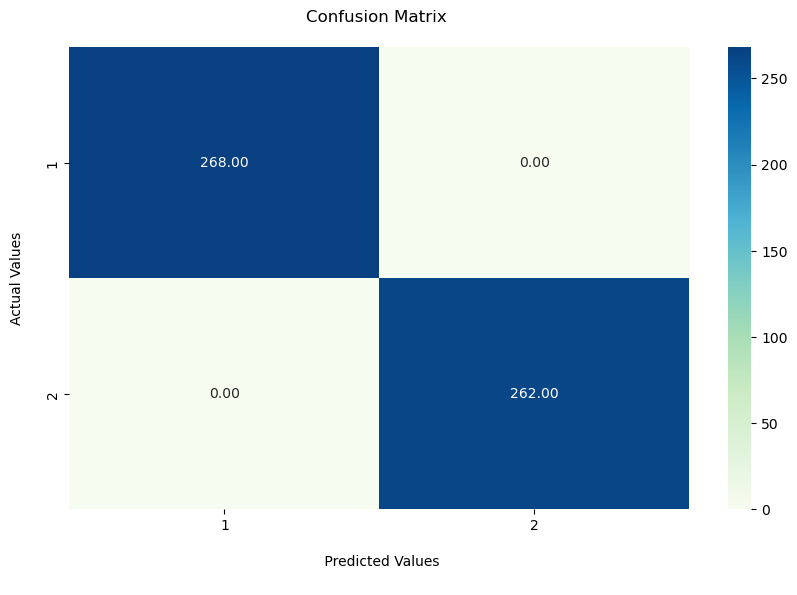

In [99]:
plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_train,fullClassTree.predict(X_train)), annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(['1','2'])
fx.yaxis.set_ticklabels(['1','2'])
plt.show()

In [100]:
from pandas import read_table
from pandas import set_option
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [101]:
fullClassTree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 1,
 'splitter': 'best'}

In [102]:
fullClassTree.tree_.max_depth


18

In [103]:
fullClassTree.tree_.node_count

109

In [104]:
feature_names = list(X.columns)
feature_names

['food',
 'good',
 'great',
 'service',
 'place',
 'also',
 'one',
 'like',
 'menu',
 'would',
 'really',
 'us',
 'time',
 'delicious',
 'well',
 'dish',
 'nice',
 'got',
 'get',
 'came',
 'experience',
 'ordered',
 'definitely',
 'table',
 'best',
 'bit',
 'back',
 'sauce',
 'dishes',
 'go',
 'server',
 'recommend',
 'come',
 'made',
 'toronto',
 'try',
 'amazing',
 'could',
 'night',
 'meal',
 'chicken',
 'ive',
 'dinner',
 'bar',
 'staff',
 'even',
 'little',
 'fresh',
 'small',
 'pretty',
 'much',
 'im',
 'first',
 'wasnt',
 'ramen',
 'didnt',
 'drinks',
 'taste',
 'quite',
 'dessert',
 'dining',
 'perfect',
 'course',
 'steak',
 'love',
 'order',
 'special',
 'friendly',
 'pasta',
 'super',
 'excellent',
 'went',
 'side',
 'everything',
 'spot',
 'beef',
 'sweet',
 'ambiance',
 'next',
 'enjoyed',
 'right',
 'every',
 'pork',
 'salad',
 'crispy',
 'dont',
 'bread',
 'youre',
 'cooked',
 'wait',
 'nothing',
 'loved',
 'perfectly',
 'tried',
 'fried',
 'two',
 'overall',
 'wine',
 '

In [105]:
y.unique()

array([1, 0], dtype=int64)

In [106]:
list_int = list(y.unique())
list_int

[1, 0]

In [107]:
class_names = list(map(str, list_int))
class_names

['1', '0']

In [108]:
text_representation = tree.export_text(fullClassTree, feature_names=feature_names)
print(text_representation)

|--- nothing <= 0.50
|   |--- wasnt <= 0.50
|   |   |--- like <= 0.50
|   |   |   |--- lot <= 0.50
|   |   |   |   |--- considering <= 0.50
|   |   |   |   |   |--- districtits <= 0.50
|   |   |   |   |   |   |--- young <= 0.50
|   |   |   |   |   |   |   |--- enough <= 0.50
|   |   |   |   |   |   |   |   |--- mediocre <= 0.50
|   |   |   |   |   |   |   |   |   |--- inattentive <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- marginal <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 8
|   |   |   |   |   |   |   |   |   |   |--- marginal >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- inattentive >  0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- mediocre >  0.50
|   |   |   |   |   |   |   |   |   |--- th <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- th >  0.50
|   |   |   |   |   |  

In [109]:
with open('fullClassTree.log', 'w') as fout:
    fout.write(text_representation)

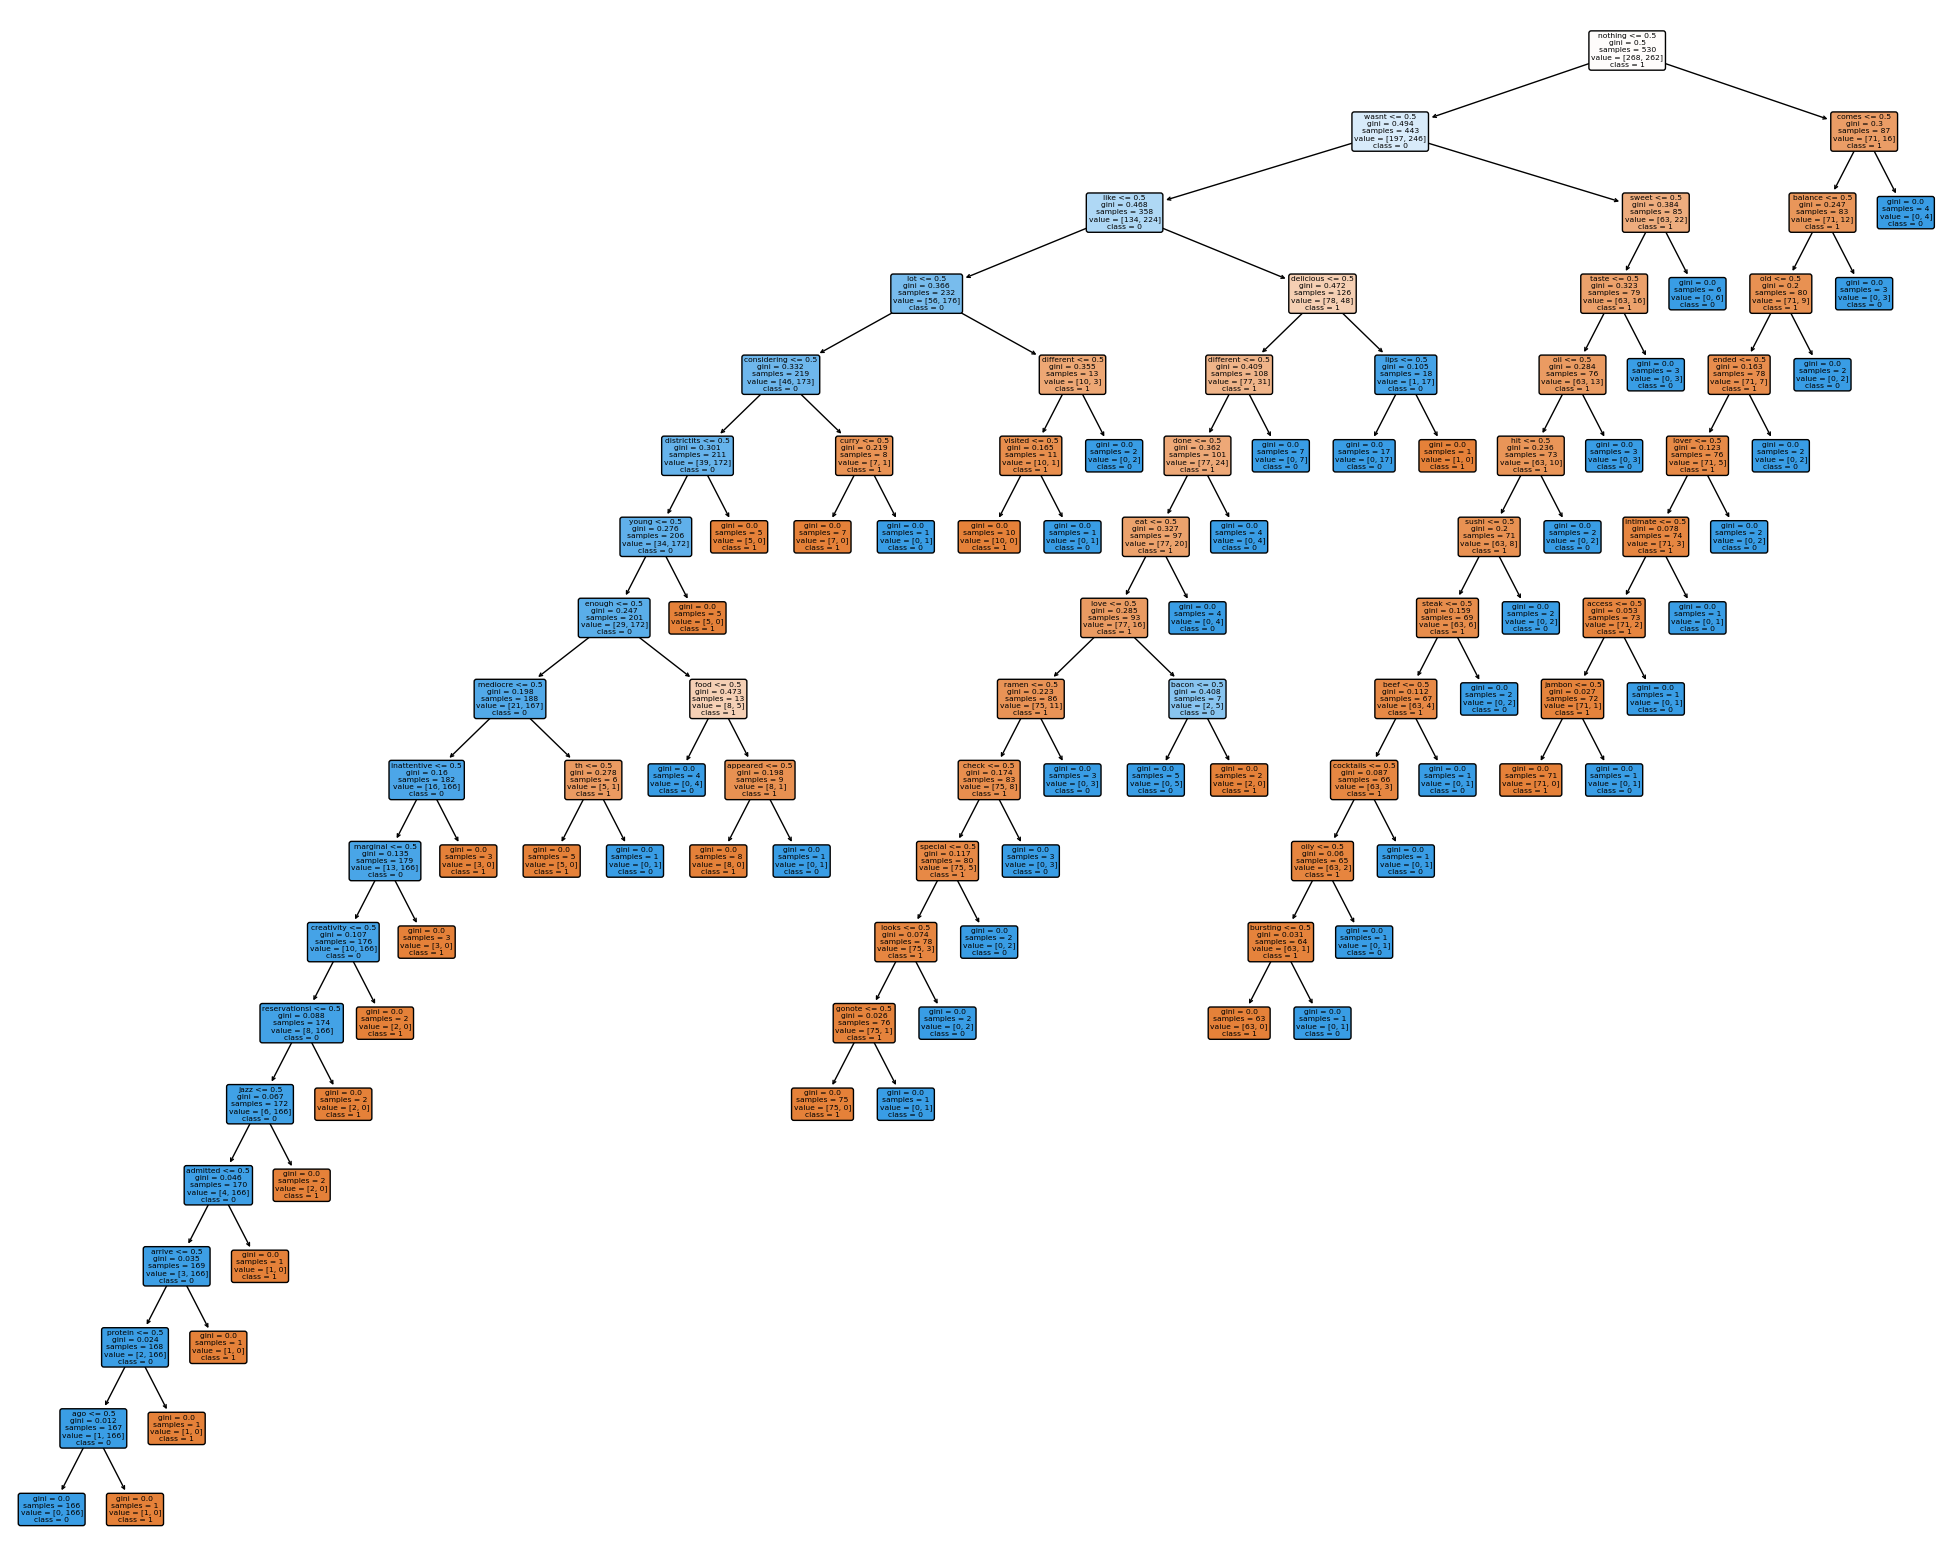

In [110]:
fig = plt.figure(figsize=(25, 20))
tree.plot_tree(fullClassTree, feature_names=feature_names, class_names=class_names,
              rounded=True, filled=True)
fig.savefig('fullClassTree.png')

In [111]:
export_graphviz(fullClassTree, out_file = 'fullClassTree.dot',
                feature_names=feature_names, class_names=class_names,
              rounded=True, filled=True)

In [112]:
treeClassifier = DecisionTreeClassifier(random_state=1)

In [113]:
scores = cross_val_score(treeClassifier, X_train, y_train, cv=5)

In [114]:
print('Accuracy scores of each fold: ',[f'{acc:.3f}' for acc in scores])

Accuracy scores of each fold:  ['0.849', '0.811', '0.840', '0.717', '0.840']


In [124]:
param_grid = [
  {'max_depth': [1,2,3,4,5,8,16,32]},
  {'max_leaf_nodes': list(range(2, 20, 1))},
  {'min_impurity_decrease': [1.0, 2.0, 3.0]},
 ]

In [125]:
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5)

In [126]:
gridSearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1),
             param_grid=[{'max_depth': [1, 2, 3, 4, 5, 8, 16, 32]},
                         {'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                             13, 14, 15, 16, 17, 18, 19]},
                         {'min_impurity_decrease': [1.0, 2.0, 3.0]}])

In [127]:
print('Initial Score: ', gridSearch.best_score_)

Initial Score:  0.8113207547169811


In [128]:
print('Initial Parameters: ', gridSearch.best_params_)

Initial Parameters:  {'max_depth': 32}


In [140]:
param_grid = [
  {'max_depth': list(range(2,40,2))},
  {'max_leaf_nodes': list(range(2, 20, 1))},
  {'min_impurity_decrease': list(range(1, 5, 1))},
 ]

In [141]:
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5)

In [142]:
gridSearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1),
             param_grid=[{'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22,
                                        24, 26, 28, 30, 32, 34, 36, 38]},
                         {'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                             13, 14, 15, 16, 17, 18, 19]},
                         {'min_impurity_decrease': [1, 2, 3, 4]}])

In [143]:
print('Improved Score: ', gridSearch.best_score_)

Improved Score:  0.8132075471698114


In [144]:
print('Improved Parameters: ', gridSearch.best_params_)

Improved Parameters:  {'max_depth': 18}


In [145]:
bestClassTree = gridSearch.best_estimator_

In [146]:
classificationSummary(y_train, bestClassTree.predict(X_train))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual   0   1
     0 268   0
     1   0 262


In [147]:
classificationSummary(y_test, bestClassTree.predict(X_test))

Confusion Matrix (Accuracy 0.8465)

       Prediction
Actual   0   1
     0 111   0
     1  35  82
